In [1]:
from copy import deepcopy
from collections import defaultdict

In [2]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

In [3]:
def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen

In [4]:
def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen

# Heuristics

In [5]:
def maxo(literal_clauseNum, return_counts=False):
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

In [6]:
def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)

    return literal

In [7]:
def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

In [22]:
def DPLL(literal_clauseNum, clauseNum_clause, literal_boolen, depth=0, algo='maxo'):
    depth += 1
    
    empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
    if empty_clause:
#         print("Empty clause")
        return False, None, depth
    
    literal_clauseNum, clauseNum_clause, literal_boolen = pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
    
    if clauseNum_clause == {}:
        return True, literal_boolen, depth
    
    literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=algo)
    
    literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), deepcopy(literal_boolen))
    doable, mapping, total_depth_T = DPLL(literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T, depth, algo=algo)
    
#     print(literal, 'T', doable)
    
    if doable:
        return True, mapping, total_depth_T
    
    literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = set_var(literal, False, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), deepcopy(literal_boolen))
    doable, mapping, total_depth_F = DPLL(literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F, depth, algo=algo)
    
#     print(literal, 'F', doable)
    
    if doable:
        return True, mapping, total_depth_T + total_depth_F
    
    return False, None, total_depth_T + total_depth_F

In [23]:
# Checking DPLL
import os

directory = 'Tests'
all_doable = []
maxo_depths = []
moms_depths = []
mams_depths = []
jw_depths = []
count = 0
for filename in os.listdir(directory):
    if count % 100 == 0:
        print(count)
    count += 1
    input_file = os.path.join(directory, filename)
    literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses = parse_input(input_file)
    
    doable, mapping, total_depth = DPLL(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo')
    maxo_depths.append(total_depth)
    
    doable, mapping, total_depth = DPLL(literal_clauseNum, clauseNum_clause, literal_boolen, algo='moms')
    moms_depths.append(total_depth)
    
    doable, mapping, total_depth = DPLL(literal_clauseNum, clauseNum_clause, literal_boolen, algo='mams')
    mams_depths.append(total_depth)
    
    doable, mapping, total_depth = DPLL(literal_clauseNum, clauseNum_clause, literal_boolen, algo='jw')
    jw_depths.append(total_depth)
    
    all_doable.append(doable)
print("Done")
# print("All doable:", all_doable)

0
100
200
300
400
500
600
700


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8b in position 1: invalid start byte

In [24]:
print("Count:", count)
sum(all_doable)

Count: 747


746

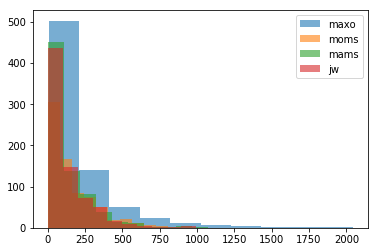

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt

a = 0.6
z = plt.hist(maxo_depths, alpha=a, label='maxo')
z = plt.hist(moms_depths, alpha=a, label='moms')
z = plt.hist(mams_depths, alpha=a, label='mams')
z = plt.hist(jw_depths, alpha=a, label='jw')

plt.legend()

In [14]:
mams_depths

[293,
 351,
 1485,
 578,
 15,
 78,
 507,
 9,
 10,
 307,
 127,
 25,
 24,
 280,
 1097,
 33,
 665,
 454,
 338,
 57,
 19,
 40,
 180,
 14,
 51,
 203,
 76,
 8,
 1030,
 95,
 93,
 228,
 252,
 157,
 15,
 232,
 250,
 198,
 236,
 8,
 15,
 1366,
 11,
 20,
 1132,
 831,
 24,
 415,
 60,
 295,
 977,
 109,
 8,
 22,
 249,
 12,
 424,
 697,
 65,
 238,
 26,
 13,
 14,
 32,
 66,
 62,
 345,
 458,
 324,
 195,
 16,
 175,
 75,
 9,
 540,
 29,
 36,
 44,
 26,
 110,
 16,
 55,
 764,
 222,
 53,
 374,
 433,
 45,
 14,
 606,
 14,
 349,
 271,
 338,
 69,
 77,
 126,
 128,
 104,
 12,
 16,
 78,
 86,
 205,
 121,
 205,
 10,
 161,
 80,
 9,
 182,
 911,
 165,
 57,
 35,
 22,
 84,
 167,
 65,
 179,
 119,
 350,
 116,
 1631,
 11,
 76,
 27,
 10,
 265,
 148,
 70,
 147,
 22,
 339,
 100,
 15,
 15,
 67,
 484,
 45,
 268,
 38,
 50,
 10,
 69,
 15,
 14,
 19,
 10,
 579,
 33,
 239,
 204,
 22,
 425,
 216,
 24,
 211,
 175,
 11,
 66,
 13,
 14,
 36,
 11,
 15,
 15,
 419,
 10,
 520,
 67,
 56,
 37,
 9,
 78,
 97,
 296,
 26,
 189,
 292,
 135,
 13,
 725,
 

In [15]:
jw_depths

[293,
 351,
 1485,
 578,
 15,
 78,
 507,
 9,
 10,
 307,
 127,
 25,
 24,
 280,
 1097,
 33,
 665,
 454,
 338,
 57,
 19,
 40,
 180,
 14,
 51,
 203,
 76,
 8,
 1030,
 95,
 93,
 228,
 252,
 157,
 15,
 232,
 250,
 198,
 236,
 8,
 15,
 1366,
 11,
 20,
 1132,
 831,
 24,
 415,
 60,
 295,
 977,
 109,
 8,
 22,
 249,
 12,
 424,
 697,
 65,
 238,
 26,
 13,
 14,
 32,
 66,
 62,
 345,
 458,
 324,
 195,
 16,
 175,
 75,
 9,
 540,
 29,
 36,
 44,
 26,
 110,
 16,
 55,
 764,
 222,
 53,
 374,
 433,
 45,
 14,
 606,
 14,
 349,
 271,
 338,
 69,
 77,
 126,
 128,
 104,
 12,
 16,
 78,
 86,
 205,
 121,
 205,
 10,
 161,
 80,
 9,
 182,
 911,
 165,
 57,
 35,
 22,
 84,
 167,
 65,
 179,
 119,
 350,
 116,
 1631,
 11,
 76,
 27,
 10,
 265,
 148,
 70,
 147,
 22,
 339,
 100,
 15,
 15,
 67,
 484,
 45,
 268,
 38,
 50,
 10,
 69,
 15,
 14,
 19,
 10,
 579,
 33,
 239,
 204,
 22,
 425,
 216,
 24,
 211,
 175,
 11,
 66,
 13,
 14,
 36,
 11,
 15,
 15,
 419,
 10,
 520,
 67,
 56,
 37,
 9,
 78,
 97,
 296,
 26,
 189,
 292,
 135,
 13,
 725,
 